# Model Inference
Infer from a cosmological model via MCMC samplers. 

In [93]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, jit, vmap, grad, debug, tree

from functools import partial
from getdist import plots
from numpyro import infer

%matplotlib inline
%load_ext autoreload
%autoreload 2

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save

import mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2024/12/14 01:21:38 INFO mlflow.tracking.fluent: Experiment with name 'infer' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/517275644693012783', creation_time=1734135699021, experiment_id='517275644693012783', last_update_time=1734135699021, lifecycle_stage='active', name='infer', tags={}>

## Config and fiduc

In [97]:
import argparse

def get_save_dir(**kwargs):
    dir = os.path.expanduser("~/scratch/pickles/")
    # dir = os.path.expanduser("/lustre/fsn1/projects/rech/fvg/uvs19wt/pickles/")

    dir += f"m{kwargs['mesh_shape'][0]:d}_b{kwargs['box_shape'][0]:.1f}"
    dir += f"_al{kwargs['a_lpt']:.1f}_ao{kwargs['a_obs']:.1f}_lo{kwargs['lpt_order']:d}_pc{kwargs['precond']:d}_ob{kwargs['obs']}/"
    return dir

def create_parser():
    parser = argparse.ArgumentParser(description='Parse configuration parameters.')
    parser.add_argument('-m', '--mesh_length', type=int, help='Mesh length')
    parser.add_argument('-b', '--box_length', type=float, help='Box length', default=None)
    parser.add_argument('-al', '--a_lpt', type=float, help='a lpt', default=0.1)
    parser.add_argument('-ao', '--a_obs', type=float, help='a obs', default=0.5)
    parser.add_argument('-lo', '--lpt_order', type=int, help='lpt order')
    parser.add_argument('-pc', '--precond', type=int, help='preconditioning')
    parser.add_argument('-o', '--obs', type=str, help='observable type', default='mesh')
    return parser


config = {
          'mesh_shape':3 * (64,),
          'box_shape':3 * (320.,),
          'a_lpt':0.1,
          'a_obs':0.5,
          'lpt_order':1,
          'precond':1,
          'obs':'mesh'
          }

# parser = create_parser()
# args = parser.parse_args()
# config = {
#           'mesh_shape':3 * (args.mesh_length,),
#           'box_shape':3 * (args.box_length if args.box_length is not None else 5 * args.mesh_length,), 
#           'a_lpt':args.a_lpt if args.lpt_order > 0 else args.a_obs,
#           'a_obs':args.a_obs,
#           'lpt_order':args.lpt_order,
#           'precond':args.precond,
#           'obs':args.obs
#           }


save_dir = get_save_dir(**config)
model = FieldLevelModel(**default_config | config)
# print(model)
# model.render(0,1)

if not os.path.exists(save_dir):
    # Predict and save fiducial
    truth = {'Omega_m': 0.31, 
            'sigma8': 0.81, 
            'b1': 1., 
            'b2':0., 
            'bs2':0., 
            'bn2': 0.}

    model.reset()
    truth = model.predict(samples=truth, hide_base=False, frombase=True)
    
    print(f"Saving model and truth at {save_dir}")
    os.mkdir(save_dir)
    model.save(save_dir)    
    pdump(truth, save_dir + "truth.p")
else:
    print(f"Loading truth from {save_dir}")
    truth = pload(save_dir + "truth.p")

model.condition({'obs': truth['obs']})
model.obs_meshk = truth['obs']
model.block()
# model.render(0,1)

Loading truth from /feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_al0.1_ao0.5_lo1_pc1_obmesh/


In [98]:
init_params_ = jit(vmap(partial(model.init_model, base=True)))(jr.split(jr.key(43), 100))

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


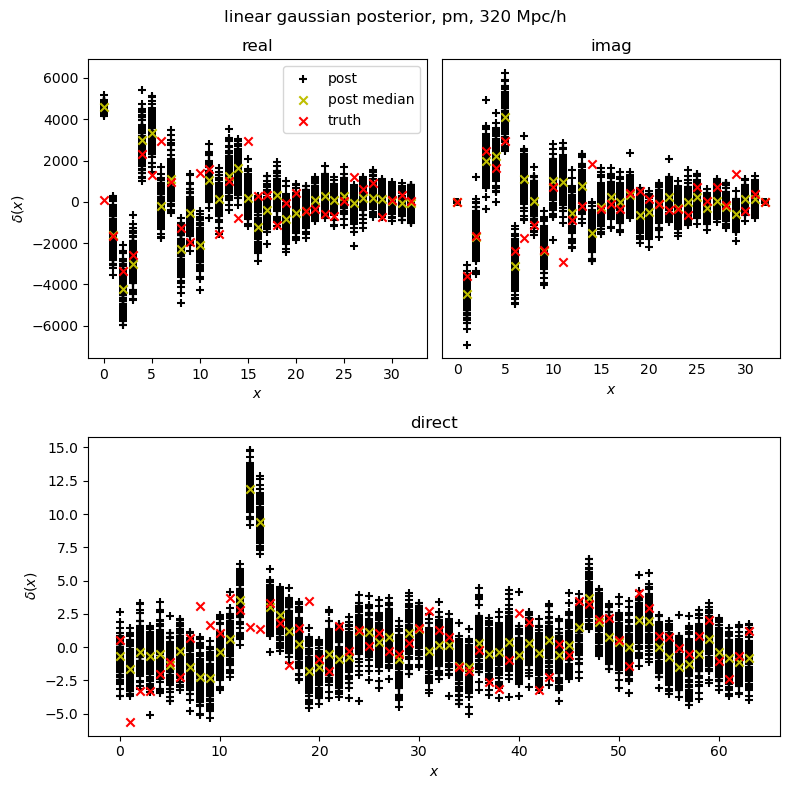

In [99]:
meshes = []
meshes_true = []
meshes.append(init_params_['init_mesh'][:,0,0].real)
meshes_true.append(truth['init_mesh'][0,0].real)
meshes.append(init_params_['init_mesh'][:,0,0].imag)
meshes_true.append(truth['init_mesh'][0,0].imag)
meshes.append(vmap(jnp.fft.irfftn)(init_params_['init_mesh'])[:,0,0])
meshes_true.append(jnp.fft.irfftn(truth['init_mesh'])[0,0])

plt.figure(figsize=(8,8))
labels = ['real', 'imag', 'direct']
for i_plt, (mesh, mesh_true) in enumerate(zip(meshes, meshes_true)):
    if i_plt == 0:
        plt.subplot(2,2,i_plt+1)
    elif i_plt == 1:
        plt.subplot(2,2,i_plt+1, sharey=plt.gca())
        plt.gca().tick_params(labelleft=False, length=0)
    elif i_plt == 2:
        plt.subplot(2,1,2)

    for i in range(mesh_true.shape[0]):
        plt.scatter(100*(i,), mesh[:,i], c='k', marker='+', label='post')
        plt.scatter(i, jnp.median(mesh[:,i]), c='y', marker='x', label='post median')
        plt.scatter(i, mesh_true[i], c='r', marker='x', label='truth')
        plt.legend() if i == 0 and i_plt == 0 else None
        plt.xlabel('$x$'), plt.ylabel('$\\delta(x)$') if i_plt==0 or i_plt==2 else None
        plt.title(labels[i_plt])
plt.suptitle('linear gaussian posterior, pm, 320 Mpc/h')
plt.tight_layout()
mlflow.log_figure(plt.gcf(), "init_mesh_pm.svg")

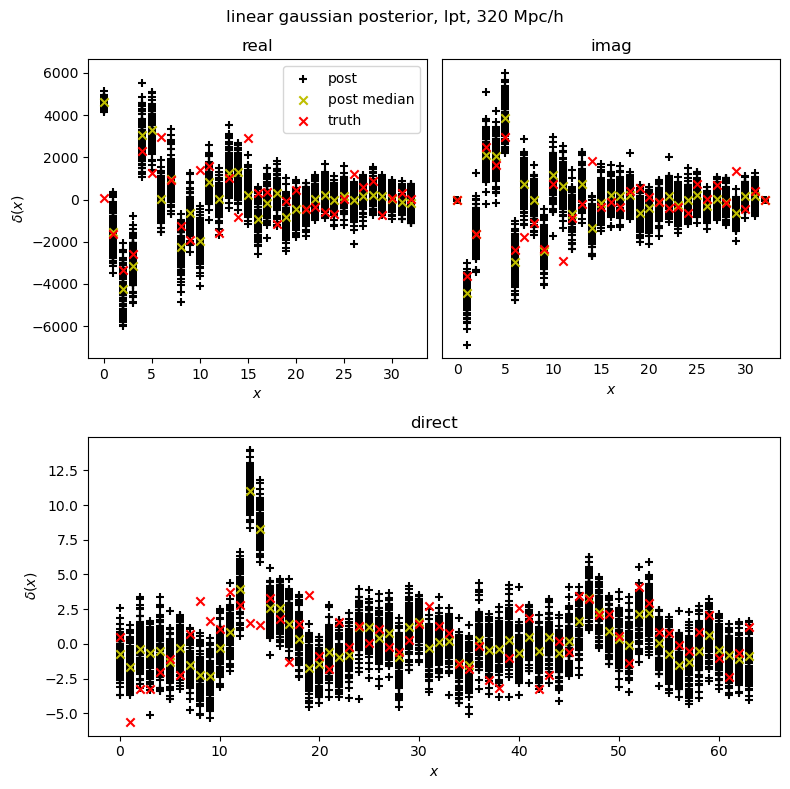

In [96]:
meshes = []
meshes_true = []
meshes.append(init_params_['init_mesh'][:,0,0].real)
meshes_true.append(truth['init_mesh'][0,0].real)
meshes.append(init_params_['init_mesh'][:,0,0].imag)
meshes_true.append(truth['init_mesh'][0,0].imag)
meshes.append(vmap(jnp.fft.irfftn)(init_params_['init_mesh'])[:,0,0])
meshes_true.append(jnp.fft.irfftn(truth['init_mesh'])[0,0])

plt.figure(figsize=(8,8))
labels = ['real', 'imag', 'direct']
for i_plt, (mesh, mesh_true) in enumerate(zip(meshes, meshes_true)):
    if i_plt == 0:
        plt.subplot(2,2,i_plt+1)
    elif i_plt == 1:
        plt.subplot(2,2,i_plt+1, sharey=plt.gca())
        plt.gca().tick_params(labelleft=False, length=0)
    elif i_plt == 2:
        plt.subplot(2,1,2)

    for i in range(mesh_true.shape[0]):
        plt.scatter(100*(i,), mesh[:,i], c='k', marker='+', label='post')
        plt.scatter(i, jnp.median(mesh[:,i]), c='y', marker='x', label='post median')
        plt.scatter(i, mesh_true[i], c='r', marker='x', label='truth')
        plt.legend() if i == 0 and i_plt == 0 else None
        plt.xlabel('$x$'), plt.ylabel('$\\delta(x)$') if i_plt==0 or i_plt==2 else None
        plt.title(labels[i_plt])
plt.suptitle('linear gaussian posterior, lpt, 320 Mpc/h')
plt.tight_layout()
mlflow.log_figure(plt.gcf(), "init_mesh.svg")

## Run

### NUTS, HMC

In [ ]:
sampler = "NUTS"
n_samples, max_tree_depth, n_runs, n_chains = 64, 10, 10, 8
save_path = save_dir + f"s{sampler}_nc{n_chains:d}_ns{n_samples:d}"


nuts_kernel = infer.NUTS(
    model=model.model,
    # init_strategy=numpyro.infer.init_to_value(values=fiduc_params)
    adapt_mass_matrix=True,
    step_size=1e-4, 
    adapt_step_size=True,
    max_tree_depth=max_tree_depth,
    target_accept_prob=0.65,)

hmc_kernel = infer.HMC(
    model=model.model,
    # init_strategy=numpyro.infer.init_to_value(values=fiduc_params),
    adapt_mass_matrix=True,
    step_size=1e-3, 
    adapt_step_size=True,
    # Rule of thumb (2**max_tree_depth-1)*step_size_NUTS/(2 to 4), compare with default 2pi.
    trajectory_length= 1023 * 1e-3 / 4, 
    target_accept_prob=0.65,)

mcmc = infer.MCMC(
    sampler=nuts_kernel,
    num_warmup=n_samples,
    num_samples=n_samples, # for each run
    num_chains=n_chains,
    chain_method="vectorized",
    progress_bar=True,)


continue_run = False
if continue_run:
    mcmc.num_warmup = 0
    last_state = pload(save_path + "_last_state.p")
    mcmc.post_warmup_state = last_state

# print("mean_acc_prob:", last_state.mean_accept_prob, "\nss:", last_state.adapt_state.step_size)
# invmm = list(last_state.adapt_state.inverse_mass_matrix.values())[0][0]
# invmm.min(),invmm.max(),invmm.mean(),invmm.std()

# Init params
# init_model = model.copy()
# init_model.partial(temp=1e-2)
# init_params_ = init_model.predict(samples=n_chains)
init_params_ = jit(vmap(model.init_model))(jr.split(jr.key(43), n_chains))

In [ ]:
# mlflow.log_metric('halt',0) # 31.46s/it 4chains, 37.59s/it 8chains
mcmc_runned = sample_and_save(mcmc, n_runs, save_path, extra_fields=['num_steps'], init_params=init_params_)
# mlflow.log_metric('halt',1)

run 0/10 (warmup)


/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p